<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

In [16]:
import tensorflow as tf

In [17]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 505), reused 1389 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 35.40 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Note: switching to '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



After running the following cell restart runtime

In [18]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt

# restart the runtime afterwards

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.5/238.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.1 M

After Restarting runtime, run only below cells

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
sys.path.append('models')

#Import bert modules
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

# Unzip the downloaded data
!unzip imdb-dataset-of-50k-movie-reviews.zip

df = pd.read_csv('IMDB Dataset.csv')
df.head()


Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 78% 20.0M/25.7M [00:00<00:00, 101MB/s]
100% 25.7M/25.7M [00:00<00:00, 108MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape

(50000, 2)

In [4]:
#Replace ham with 0 and spam with 1
df['sentiment'] = df['sentiment'].replace(['positive', 'negative'], [1, 0])

<ipython-input-4-ed2d37f770e9>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace(['positive', 'negative'], [1, 0])


In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [6]:
#drop duplicates
df = df.drop_duplicates(keep = 'first')
df.shape

(49582, 2)

In [9]:
#Split the data into train and validation

train_df, remaining = train_test_split(df, random_state=42, train_size=0.8, stratify=df.sentiment.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.5, stratify=remaining.sentiment.values)
train_df.shape, valid_df.shape

((39665, 2), (4958, 2))

In [10]:
#Implementing the input pipeline

train_data = tf.data.Dataset.from_tensor_slices((train_df['review'].values, train_df['sentiment'].values))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df.review.values, valid_df.sentiment.values))

#Check the data
for text, label in train_data.take(1):
  print(text)
  print(label)

tf.Tensor(b'I am one of Jehovah\'s Witnesses and I also work in an acute care medical facility. Over the years I have seen people die from hemolytic reactions to blood transfusions, have attended numerous conferences on blood born pathogens, and have seen several patients become seriously ill from pathogens induced by transfused blood. I have also heard several Jehovah\'s Witnesses being told that they will die if they refuse blood and after 26 years in the field I have never actually seen it happen, leaving the question, "is it really unreasonable to refuse blood transfusions or is the community at large benefiting from the battle on this issue?" The issue for Jehovah\'s Witnesses is a moral one. "You must abstain from blood" is not an ambiguous statement. Thank you for this movie and allowing comments on it.', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [11]:
#Set up hyper-parameters

label_list = [0, 1]                 # Label categories
max_seq_length = 128                # maximum length of (token) input sequences
train_batch_size = 32               # batch size for training

In [12]:
#import BERT from tensorflow hub

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

##Implementing a function to convert the text data into the BERT format

In [13]:
def convert_text_to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
    example = classifier_data_lib.InputExample(guid=None,
                                               text_a=text.numpy().decode(),
                                               text_b=None,
                                               label=label.numpy())

    feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)


In [14]:
def to_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(convert_text_to_feature, inp=[text, label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }

    return (x, label_id)

In [15]:
train_data = (train_data.map(to_map,
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)
                            .shuffle(1000)
                            .batch(32, drop_remainder=True)
                            .prefetch(tf.data.experimental.AUTOTUNE))


valid_data = (valid_data.map(to_map,
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)
                            .batch(32, drop_remainder=True)
                            .prefetch(tf.data.experimental.AUTOTUNE))


In [16]:
#Check the data
train_data.take(1)

<_TakeDataset element_spec=({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(32,), dtype=tf.int32, name=None))>

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [17]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [18]:
# valid data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [25]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length, ), dtype=tf.int32,
                                         name='input_word_ids')

  input_mask = tf.keras.layers.Input(shape=(max_seq_length, ), dtype=tf.int32,
                                         name='input_mask')

  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length, ), dtype=tf.int32,
                                         name='input_type_ids')

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(2, activation = 'softmax', name='output')(drop)

  model = tf.keras.Model(
      inputs = {
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs = output)

  return model

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

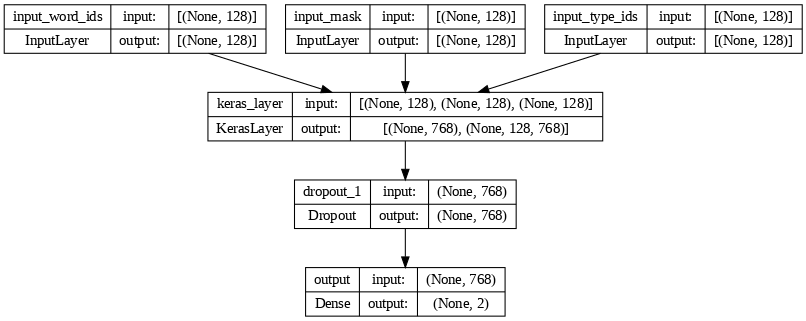

In [29]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi = 76)

In [30]:
# Train model
epochs = 6
history = model.fit(train_data,
                    validation_data = valid_data,
                    epochs = epochs,
                    verbose=1)

Epoch 1/6
1239/1239 [==============================] - 1211s 951ms/step - loss: 0.3006 - sparse_categorical_accuracy: 0.8722 - val_loss: 0.2694 - val_sparse_categorical_accuracy: 0.8898
Epoch 2/6
1239/1239 [==============================] - 1179s 948ms/step - loss: 0.1902 - sparse_categorical_accuracy: 0.9255 - val_loss: 0.3192 - val_sparse_categorical_accuracy: 0.8878
Epoch 3/6
1239/1239 [==============================] - 1180s 948ms/step - loss: 0.0992 - sparse_categorical_accuracy: 0.9631 - val_loss: 0.4018 - val_sparse_categorical_accuracy: 0.8829
Epoch 4/6
1239/1239 [==============================] - 1143s 918ms/step - loss: 0.0523 - sparse_categorical_accuracy: 0.9822 - val_loss: 0.5896 - val_sparse_categorical_accuracy: 0.8746
Epoch 5/6
1239/1239 [==============================] - 1180s 948ms/step - loss: 0.0356 - sparse_categorical_accuracy: 0.9875 - val_loss: 0.5194 - val_sparse_categorical_accuracy: 0.8904
Epoch 6/6
1239/1239 [==============================] - 1143s 919ms/ste

Plot the Model Training Status

In [32]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

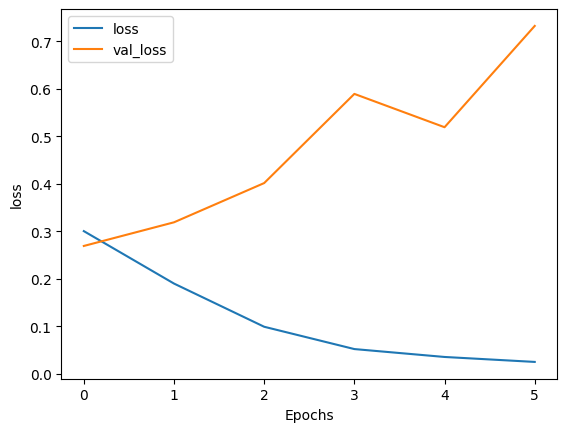

In [33]:
#plot the model loss
plot_graphs(history, 'loss')

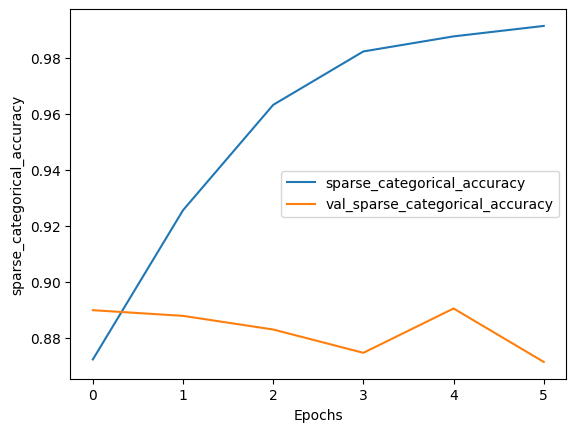

In [38]:
#Plot the model accuracy
plot_graphs(history, 'sparse_categorical_accuracy')

##Evaluating Model Performance

Plot confusion matrix for train dataset

In [69]:
test_train_data_list = list(train_df.review)
test_train_true_list = list(train_df.sentiment)

In [45]:
test_data_sample = tf.data.Dataset.from_tensor_slices((test_train_data_list, [0]*len(test_train_data_list)))
test_data_sample = (test_data_sample.map(to_map).batch(1))
preds = model.predict(test_data_sample)


39665/39665 [==============================] - 638s 16ms/step


In [75]:
#Predicted labels
pred_train_list = []
for pred in preds:
  pred_train_list.append(np.argmax(pred))


In [76]:
print(len(test_true_train_list))
print(len(pred_train_list))

39665
39665


In [77]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

1 : Positive


0 : Negative

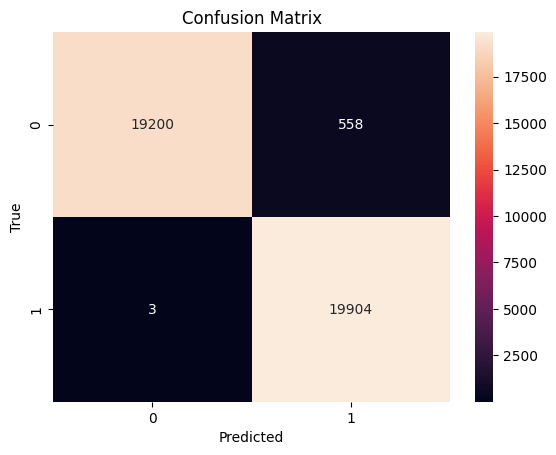

In [78]:
cm = confusion_matrix(test_train_true_list, pred_train_list)

sns.heatmap(cm, annot=True, fmt="d")


plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Plot confusion matrix for validation dataset

In [79]:
test_val_data_list = list(valid_df.review)
test_val_true_list = list(valid_df.sentiment)

In [80]:
test_data_sample = tf.data.Dataset.from_tensor_slices((test_val_data_list, [0]*len(test_val_data_list)))
test_data_sample = (test_data_sample.map(to_map).batch(1))
preds_val = model.predict(test_data_sample)

4958/4958 [==============================] - 84s 17ms/step


In [81]:
pred_val_list = []
for pred in preds_val:
  pred_val_list.append(np.argmax(pred))

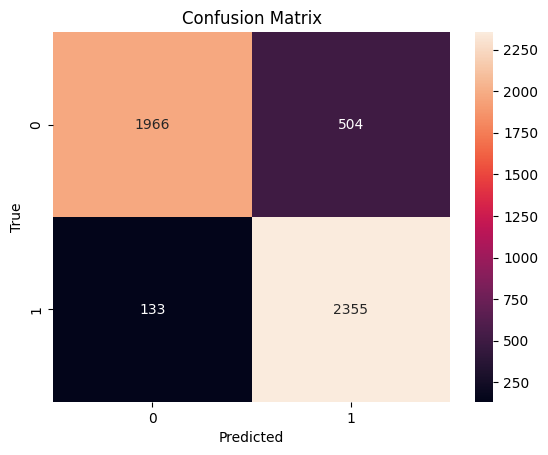

In [85]:
cm = confusion_matrix(test_val_true_list, pred_val_list)

sns.heatmap(cm, annot=True, fmt="d")


plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Evaluate model using second element of train_df

In [86]:
test_train_data_list[1]

'Amongst the standard one liner type action films, where acting and logic are checked at the door, this movie is at the top of the class. If the person in charge of casting were to have put "good" actors in this flick, it would have been worse(excepting Richard Dawson who actually did act well, if you can call playing yourself "acting"). I love this movie! The Running Man is in all likelihood God\'s gift to man(okay maybe just men). Definitely the most quotable movie of our time so I\'ll part you with my favorite line: "It\'s all part of life\'s rich pattern Brenda, and you better F*****g get used to it." Ahh, more people have been called "Brenda" for the sake of quoting this film than I can possibly imagine.'

In [87]:
text_sample = [test_train_data_list[1]]
test_data_sample = tf.data.Dataset.from_tensor_slices((text_sample, [0]*len(text_sample)))
test_data_sample = (test_data_sample.map(to_map).batch(1))
preds = model.predict(test_data_sample)

1/1 [==============================] - 0s 42ms/step


In [88]:
sentiment_dict = {1: "Positive", 0: "Negative"}

In [91]:
print("This review is",sentiment_dict[np.argmax(preds)])

This review is Positive
